<a href="https://colab.research.google.com/github/myschl/ML-DL/blob/master/CNC_Milling_Clasificatiojn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import pandas as pd
from tensorflow import keras
import numpy as np # linear algebra
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from keras.utils import to_categorical

# **Laod Data**

In [2]:
# unzipping my data folder from my google drive
from zipfile import ZipFile
bosch = '/content/drive/My Drive/SS_Thesis/CNC Milling Tool.zip'
with ZipFile(bosch, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [3]:
experiment_result = pd.read_csv("/content/train.csv")
print(f'train.csv : {experiment_result.shape}')
experiment_result

train.csv : (18, 7)


,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN
5,6,wax,6,4.0,worn,yes,no
6,7,wax,20,4.0,worn,no,NaN
7,8,wax,20,4.0,worn,yes,no
8,9,wax,15,4.0,worn,yes,no
9,10,wax,12,4.0,worn,yes,no


In [4]:
experiment_tmp = pd.read_csv("/content/experiment_01.csv")
print(f'experiment_XX.csv : {experiment_tmp.shape}')
print(experiment_tmp.columns)
experiment_tmp.head()

experiment_XX.csv : (1055, 48)
Index(['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.0,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.0,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.0,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.7,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.0,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.6,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.0,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep


Filling Nan with no when passed visual inspection column to indicate that machining_finalized is not passed

In [11]:
experiment_result['passed_visual_inspection'] = experiment_result['passed_visual_inspection'].fillna('no')

Creating the Dataset that includes both the featues and the labels

In [12]:
Data = []
for i in range(1,19):
    #load files
    exp_num = '0' + str(i) if i < 10 else str(i)
    data = pd.read_csv(f"/content/experiment_{exp_num}.csv")

    #load each experiment result row
    exp_result_row = experiment_result[experiment_result['No'] == i]
    data['exp_num'] = i

    #add experiment settings to features
    data['material'] = exp_result_row.iloc[0]['material']
    data['feedrate'] = exp_result_row.iloc[0]['feedrate']
    data['clamp_pressure'] = exp_result_row.iloc[0]['clamp_pressure']
    
    #add experiment result to features
    data['tool_condition'] = exp_result_row.iloc[0]['tool_condition']
    data['machining_finalized'] = exp_result_row.iloc[0]['machining_finalized']
    data['passed_visual_inspection'] = exp_result_row.iloc[0]['passed_visual_inspection']

    Data.append(data)

Data = pd.concat(Data, ignore_index = True)
Data.head(-20)

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,exp_num,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,198.0,0.00,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.000,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.000000e+00,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,1,wax,6,4.0,unworn,yes,yes
1,198.0,-10.80,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.300,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.000000e+00,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
2,196.0,-17.80,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.700,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.000000e+00,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
3,194.0,-18.00,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.700,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.000000e+00,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
4,193.0,-17.90,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.600,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.000000e+00,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,1,wax,6,4.0,unworn,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25261,156.0,2.97,31.30,156.0,3.0,0.000000,4.76,0.0833,327.0,8.85,0.000474,91.6,-0.100,-50.00,91.6,0.0,0.000000,-4.150,0.0749,326.0,5.05,-3.580000e-05,28.7,0.000,0.00,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-1990.0,53.300,24.300,-1990.0,53.3,9.540000e-07,20.400,8.720000e-01,324.0,118.0,1.680000e-01,12.0,1.0,80.0,3.0,End,18,wax,3,2.5,worn,yes,yes
25262,157.0,3.03,25.00,157.0,3.0,0.000000,2.53,0.0489,327.0,7.71,0.000301,91.6,-0.100,-50.00,91.6,0.0,0.000000,-4.100,0.0766,326.0,5.34,0.000000e+00,28.7,0.000,0.00,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-1990.0,53.400,-15.800,-1990.0,53.3,-9.540000e-07,16.900,8.850000e-01,323.0,115.0,1.690000e-01,12.0,1.0,80.0,3.0,End,18,wax,3,2.5,worn,yes,yes
25263,157.0,3.13,0.00,157.0,3.0,0.000000,3.89,0.0669,327.0,7.67,0.000426,91.6,-0.100,-50.00,91.6,0.0,0.000000,-4.740,0.0758,326.0,4.26,-1.210000e-05,28.7,0.025,6.25,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-1980.0,53.400,17.800,-1980.0,53.3,0.000000e+00,18.800,8.910000e-01,324.0,119.0,1.710000e-01,12.0,1.0,80.0,3.0,End,18,wax,3,2.5,worn,yes

**Normalizing the label**

replacing 
  starting with prep,
  end with End

In [13]:
Data['Machining_Process'].value_counts().sort_index()

End              2585
Layer 1 Down     2655
Layer 1 Up       4085
Layer 2 Down     2528
Layer 2 Up       3104
Layer 3 Down     2354
Layer 3 Up       2794
Prep             1795
Repositioning    3377
Starting            1
end                 8
Name: Machining_Process, dtype: int64

In [14]:
Data.replace({'Machining_Process': {'Starting':'Prep','end':'End'}}, inplace=True)

In [15]:
Data['Machining_Process'].value_counts().sort_index()

End              2593
Layer 1 Down     2655
Layer 1 Up       4085
Layer 2 Down     2528
Layer 2 Up       3104
Layer 3 Down     2354
Layer 3 Up       2794
Prep             1796
Repositioning    3377
Name: Machining_Process, dtype: int64

# **Data Visualization**

worn      13308
unworn    11978
Name: tool_condition, dtype: int64


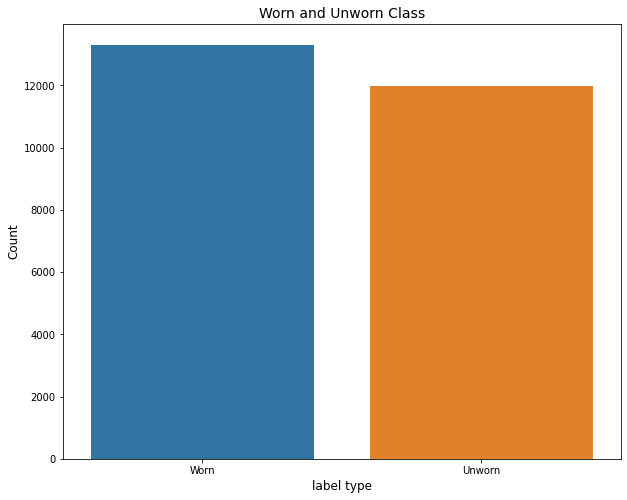

In [16]:
# Get the counts for each class in tool_condition
alabel_count = Data['tool_condition'].value_counts()
print(alabel_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=alabel_count.index, y= alabel_count.values)
plt.title('Worn and Unworn Class', fontsize=14)
plt.xlabel('label type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(alabel_count.index)), ['Worn', 'Unworn'])
plt.show()

yes    23125
no      2161
Name: machining_finalized, dtype: int64


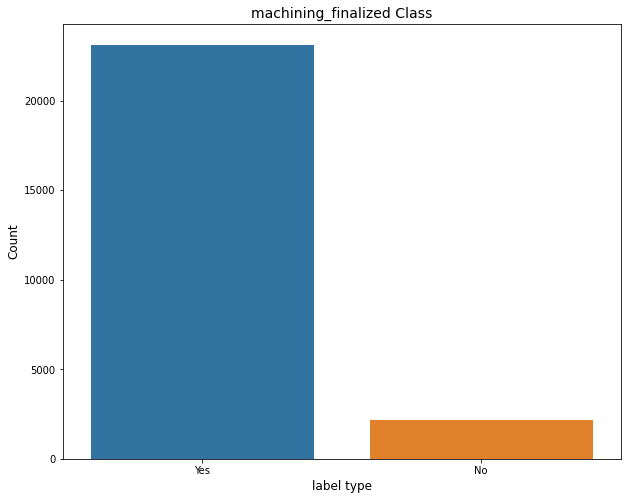

In [17]:
# Get the counts for each class in machining_finalized
alabel_count = Data['machining_finalized'].value_counts()
print(alabel_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=alabel_count.index, y= alabel_count.values)
plt.title('machining_finalized Class', fontsize=14)
plt.xlabel('label type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(alabel_count.index)), ['Yes', 'No'])
plt.show()

yes    19183
no      6103
Name: passed_visual_inspection, dtype: int64


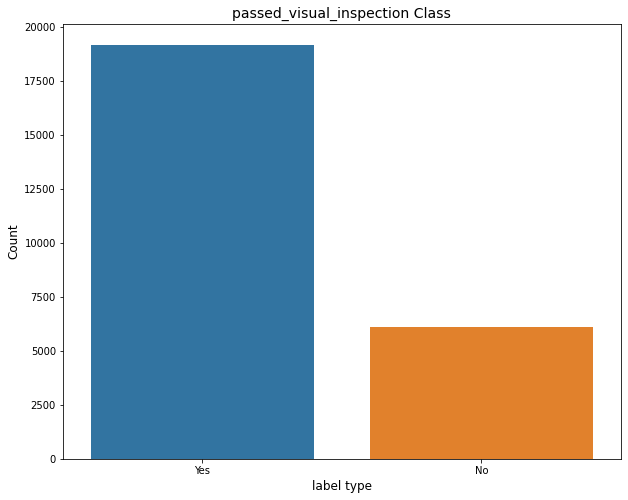

In [18]:
# Get the counts for each class in passed_visual_inspection
alabel_count = Data['passed_visual_inspection'].value_counts()
print(alabel_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=alabel_count.index, y= alabel_count.values)
plt.title('passed_visual_inspection Class', fontsize=14)
plt.xlabel('label type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(alabel_count.index)), ['Yes', 'No'])
plt.show()

# **Preprocessing the Data**

In [19]:
# count the number of missing values for each column
num_missing = (Data[Data.columns] == "NaN").sum()
# report the results
print(num_missing)
print(num_missing.sum())

X1_ActualPosition            0
X1_ActualVelocity            0
X1_ActualAcceleration        0
X1_CommandPosition           0
X1_CommandVelocity           0
X1_CommandAcceleration       0
X1_CurrentFeedback           0
X1_DCBusVoltage              0
X1_OutputCurrent             0
X1_OutputVoltage             0
X1_OutputPower               0
Y1_ActualPosition            0
Y1_ActualVelocity            0
Y1_ActualAcceleration        0
Y1_CommandPosition           0
Y1_CommandVelocity           0
Y1_CommandAcceleration       0
Y1_CurrentFeedback           0
Y1_DCBusVoltage              0
Y1_OutputCurrent             0
Y1_OutputVoltage             0
Y1_OutputPower               0
Z1_ActualPosition            0
Z1_ActualVelocity            0
Z1_ActualAcceleration        0
Z1_CommandPosition           0
Z1_CommandVelocity           0
Z1_CommandAcceleration       0
Z1_CurrentFeedback           0
Z1_DCBusVoltage              0
Z1_OutputCurrent             0
Z1_OutputVoltage             0
S1_Actua

In [20]:
Data.isnull().any().any()

False

In [21]:
Data = Data.copy()
Data['Machining_Process'] = LabelEncoder().fit_transform(Data['Machining_Process']).astype(np.int8)
Data['tool_condition'] = LabelEncoder().fit_transform(Data['tool_condition']).astype(np.int8)
Data['machining_finalized'] = LabelEncoder().fit_transform(Data['machining_finalized']).astype(np.int8)
Data['passed_visual_inspection'] = LabelEncoder().fit_transform(Data['passed_visual_inspection']).astype(np.int8)
Data.drop(['material','exp_num'], axis=1, inplace=True)
Data.head(-3)

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,198.0,0.00,0.00,198.0,0.00,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.00,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.000,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.000000e+00,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,7,6,4.0,0,1,1
1,198.0,-10.80,-350.00,198.0,-13.60,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.60,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.300,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.000000e+00,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,7,6,4.0,0,1,1
2,196.0,-17.80,-6.25,196.0,-17.90,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.30,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.700,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.000000e+00,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,7,6,4.0,0,1,1
3,194.0,-18.00,0.00,194.0,-17.90,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.30,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.700,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.000000e+00,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,7,6,4.0,0,1,1
4,193.0,-17.90,-18.80,192.0,-17.90,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.30,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.600,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.000000e+00,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,7,6,4.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25278,145.0,-2.63,37.50,145.0,-2.81,0.656000,-6.22,0.0872,327.0,9.55,0.000484,73.3,1.050,-12.50,73.3,1.04,1.770000,9.000,0.1350,326.0,7.92,3.060000e-04,28.7,0.000,0.00,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-88.4,53.300,-9.310,-88.0,53.3,-9.540000e-07,19.700,7.470000e-01,323.0,121.0,1.420000e-01,12.0,1.0,57.0,3.0,0,3,2.5,1,1,1
25279,144.0,-2.63,75.00,144.0,-2.74,0.766000,-4.67,0.0710,327.0,9.56,0.000393,73.4,1.230,0.00,73.4,1.22,1.730000,5.630,0.0983,326.0,8.67,2.810000e-04,28.7,0.000,0.00,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-83.1,53.300,-2.750,-82.6,53.3,0.000000e+00,22.400,1.100000e+00,320.0,117.0,2.130000e-01,12.0,1.0,57.0,3.0,0,3,2.5,1,1,1
25280,144.0,-2.67,12.50,144.0,-2.66,0.873000,-5.21,0.0793,327.0,9.30,0.000462,73.5,1.350,-12.50,73.5,1.39,1.680000,4.940,0.0821,326.0,8.31,2.410000e-04,28.7,-0.025,-6.25,28.7,0.0,0.000000,0.0,0.0,0.0,0.0,-77.7,53.400,30.700,-77.3,53.3,0.000000e+00,16.500,8.400000e-01,321.0,118.0,1.620000e-01,12.0,1.0,57.0,3.0,0,3,2.5,1,1,1
25281,144.0,-2.30,100.00,144.0,-2.57,0.977000,-5.05,0.0732,327.0,9.56,0.000366,73.7,1.450,-25.00,73.7,1.55,1.620000,4.680,0.0633,326.0,7.49,1.860000e-04,28.7

In [22]:
features = Data.drop(['tool_condition', 'machining_finalized', 'passed_visual_inspection'], axis = 1)
features.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,Y1_ActualAcceleration,Y1_CommandPosition,Y1_CommandVelocity,Y1_CommandAcceleration,Y1_CurrentFeedback,Y1_DCBusVoltage,Y1_OutputCurrent,Y1_OutputVoltage,Y1_OutputPower,Z1_ActualPosition,Z1_ActualVelocity,Z1_ActualAcceleration,Z1_CommandPosition,Z1_CommandVelocity,Z1_CommandAcceleration,Z1_CurrentFeedback,Z1_DCBusVoltage,Z1_OutputCurrent,Z1_OutputVoltage,S1_ActualPosition,S1_ActualVelocity,S1_ActualAcceleration,S1_CommandPosition,S1_CommandVelocity,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,-0.000001,158.0,-0.025,-6.25,158.0,0.0,0.000000,0.539,0.0167,328.0,1.84,6.430000e-07,119.0,0.0,0.00,119.0,0.0,0.000000,0.0,0.0,0.0,0.0,-361.0,0.001,0.250,-361.0,0.0,0.0,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,7,6,4.0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,0.004480,158.0,-19.800,-750.00,157.0,-24.6,-647.000000,-14.500,0.2810,325.0,37.80,1.260000e-02,119.0,-20.3,-712.00,118.0,-25.6,-674.000000,0.0,0.0,0.0,0.0,-361.0,0.000,0.250,-361.0,0.0,0.0,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,7,6,4.0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,0.005330,154.0,-32.500,0.00,154.0,-32.3,-0.000095,-7.790,0.1390,327.0,49.40,9.430000e-03,115.0,-33.7,37.50,115.0,-33.7,-0.000095,0.0,0.0,0.0,0.0,-361.0,0.000,-0.438,-361.0,0.0,0.0,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,7,6,4.0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,0.004890,151.0,-32.600,-62.50,151.0,-32.3,-0.000095,-8.130,0.1560,325.0,47.60,1.050000e-02,112.0,-33.7,-6.25,112.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,-0.001,-0.250,-361.0,0.0,0.0,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,7,6,4.0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,0.004250,148.0,-32.000,138.00,148.0,-32.3,0.000095,-13.800,0.2020,326.0,47.10,1.350000e-02,109.0,-33.6,18.80,108.0,-33.7,0.000000,0.0,0.0,0.0,0.0,-361.0,0.000,-0.188,-361.0,0.0,0.0,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,7,6,4.0


In [23]:
# finding missing and categorical values


col_missing_values = [col for col in features.columns
                     if features[col].isnull().any() and features[col].dtype]

# col wit numerical values which is null in this project
col_numerical_values = [col for col in features.columns if features[col].dtype in ['int64', 'float64']]

# col with categorical values
col_categorical_values = [col for col in features.columns 
                         if features[col].dtype == 'object']

#missing values cout per col
missing_val_count_by_column = (features.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])
print(col_categorical_values)
print(col_numerical_values)

Series([], dtype: int64)
[]
['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition', 'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition', 'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity', 'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity', 'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition', 'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition', 'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback', 'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage', 'S1_OutputPower', 'S1_SystemInertia', 'M1_CURRENT_PROGRAM_NUMBE

**PCA**

In [24]:
# scalling the features 
Scaler =StandardScaler()
s_features =Scaler.fit_transform(features)

# Create a PCA that will retain 99% of variance
pca = PCA(n_components=0.99, whiten=True)
# Conduct PCA
pca_features = pca.fit_transform(s_features)
# Show results
print("Original number of features:", features.shape[1])
print("Reduced number of features:", pca_features.shape[1])

Original number of features: 50
Reduced number of features: 29


In [25]:
pca_features

array([[-1.91847112, -0.25404615,  0.21703987, ...,  0.98716385,
        -0.64710961, -0.72721905],
       [-1.31037969,  5.77811943, -0.27797356, ...,  0.2860895 ,
         0.55629937, -1.98779917],
       [-1.44781083,  6.24744618, -1.10798947, ..., -0.6305137 ,
        -0.42369405, -0.57175882],
       ...,
       [ 0.66580423, -0.34152727, -0.78404935, ..., -0.02327893,
        -0.45529226,  0.56593969],
       [ 0.70080117, -0.17088909, -0.74140451, ..., -0.2467377 ,
         0.29445225,  0.30268362],
       [ 0.68404868, -0.27264395, -0.76620541, ..., -0.51887735,
         0.46779791,  0.35755015]])

# **Model Prediction**

In [46]:
def get_Model_prediction(model, test_data, test_labels):
  import numpy as np

  # # Evaluation on test dataset
  # test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
  # print("Loss on test set: ", test_loss)
  # print("Accuracy on test set: ", test_score)
  
  preds = model.predict(test_data, batch_size=16)
  preds = np.argmax(preds, axis=-1)

  # orig_test_labels = np.argmax(test_labels, axis=-1)

  print(test_labels)
  print(preds)

  return preds, test_labels

# **Model Evaluation**

**Evaluation Matrics**

In [26]:
def get_Evaluation_matrics(preds, orig_test_labels):

  # Get the confusion matrix
  cm  = confusion_matrix(orig_test_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
  plt.xticks(range(2), ['Fail', 'Pass'], fontsize=16)
  plt.yticks(range(2), ['Fail', 'Pass'], fontsize=16)
  plt.show()

  # Calculate Precision and Recall
  tn, fp, fn, tp = cm.ravel()
  Accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  specificity = tn/(tn+fp)
  F1_score = 2*tp/(2*tp+fp+fn)

  print("Accuracy of the model is {:.5f}".format(Accuracy))
  print("Recall of the model is {:.5f}".format(recall))
  print("Precision of the model is {:.5f}".format(precision))
  print("specificity of the model is {:.5f}".format(specificity))
  print("F1_score of the model is {:.5f}".format(F1_score))

**ROC Curve**

In [27]:
def get_model_ROC_AUC_curve(model_pred, test_labels, label=None):
    import numpy as np

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(test_labels, model_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')

    auc_score = auc(fpr, tpr)
    print('AUC Score : ', auc_score)

**Model Accuracy**

In [39]:
def plot_Model_Accuracy(History, epoch):
  history_dict2 = History.history
  acc_values2 = history_dict2['accuracy']
  val_acc_values2 = history_dict2['val_accuracy']

  epochs = range(1, epoch + 1)
  plt.plot(epochs, acc_values2, 'b-', label='training Accuracy')
  plt.plot(epochs, val_acc_values2, 'r-', label='validation Accuracy')
  plt.title('trainin/validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.rcParams['axes.facecolor'] = 'white'
  plt.rcParams['axes.edgecolor'] = 'white'
  plt.rcParams['axes.grid'] = True
  plt.rcParams['grid.alpha'] = 1
  plt.rcParams['grid.color'] = "#cccccc"
  plt.show()

**Model Loos**

In [40]:
def plot_Model_loss(History, epoch):
  history_dict2 = History.history
  loss_values2 = history_dict2['loss']
  val_loss_values2 = history_dict2['val_loss']

  epochs = range(1, epoch + 1)
  plt.plot(epochs, loss_values2, 'b-', label='training loos')
  plt.plot(epochs, val_loss_values2, 'r-', label='validation loss')
  plt.title('trainin/validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.rcParams['axes.facecolor'] = 'white'
  plt.rcParams['axes.edgecolor'] = 'white'
  plt.rcParams['axes.grid'] = True
  plt.rcParams['grid.alpha'] = 1
  plt.rcParams['grid.color'] = "#cccccc"
  plt.show()

# **Models Building**

# **1. tool_condition**

**XG Boost**

In [28]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

label1 = Data.tool_condition
train_data, test_data, train_labels, test_labels = train_test_split(s_features, label1, test_size = 0.20, random_state = 123)

<Figure size 432x288 with 0 Axes>

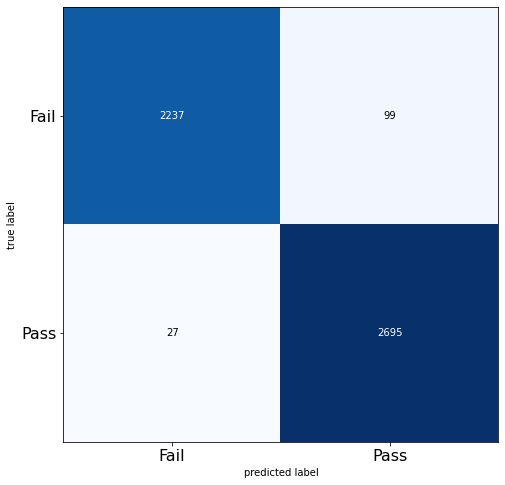

Accuracy of the model is 0.97509
Recall of the model is 0.99008
Precision of the model is 0.96457
specificity of the model is 0.95762
F1_score of the model is 0.97716


In [29]:
XG_model = XGBClassifier()

XG_model.fit(train_data, train_labels)

preds = XG_model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9738503429690094


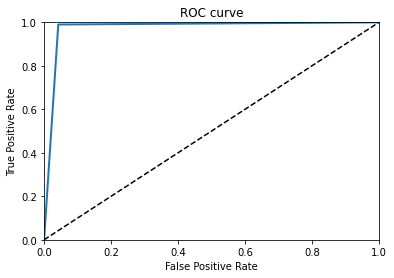

In [30]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**RF**

<Figure size 432x288 with 0 Axes>

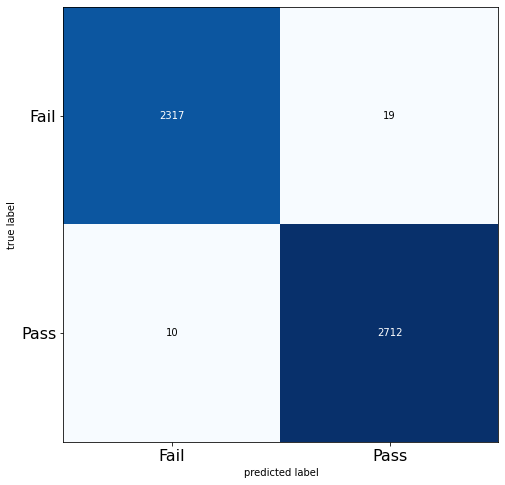

Accuracy of the model is 0.99427
Recall of the model is 0.99633
Precision of the model is 0.99304
specificity of the model is 0.99187
F1_score of the model is 0.99468


In [31]:
model = RandomForestClassifier()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9940963345344378


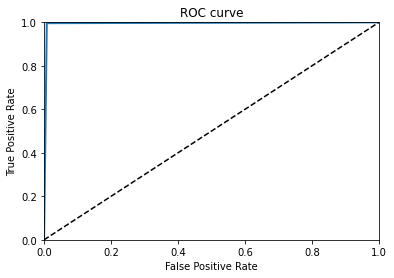

In [32]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**SVM**

<Figure size 432x288 with 0 Axes>

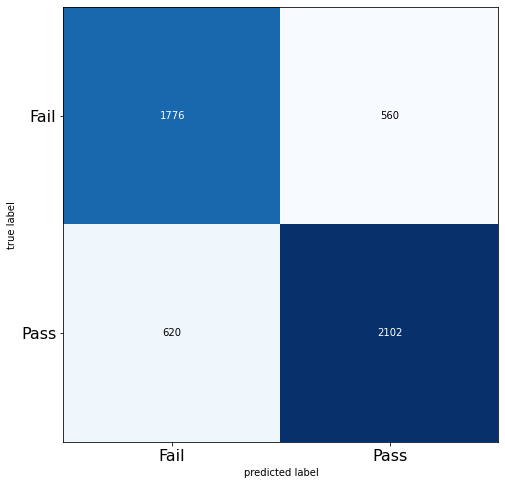

Accuracy of the model is 0.76671
Recall of the model is 0.77223
Precision of the model is 0.78963
specificity of the model is 0.76027
F1_score of the model is 0.78083


In [33]:
model = SVC()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.7662501383954184


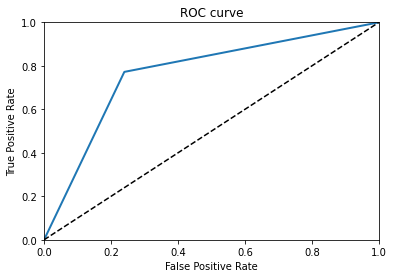

In [34]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**ANN**

In [35]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

In [54]:
from imblearn.over_sampling import SMOTE


oversample = SMOTE()
X, y = oversample.fit_sample(features, label1)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.20, random_state = 123)
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, train_size = 0.85, random_state = 123)

train_data = np.array(train_data)
valid_data = np.array(valid_data)
test_data = np.array(test_data)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

y.iloc[:,0].value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    13308
0    13308
Name: 0, dtype: int64

In [59]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(1024, input_shape = (50,), activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_history = model.fit(train_data,
                          train_labels,
                          epochs=150,
                          batch_size=16,
                          validation_data=(valid_data, valid_labels),
                          # callbacks=[early_stopping_cb]
                          )


Epoch 1/150
1132/1132 [==============================] - 7s 7ms/step - loss: 0.7073 - accuracy: 0.4952 - val_loss: 0.6961 - val_accuracy: 0.4530
Epoch 2/150
1132/1132 [==============================] - 7s 6ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6983 - val_accuracy: 0.5081
Epoch 3/150
1132/1132 [==============================] - 7s 6ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6937 - val_accuracy: 0.5069
Epoch 4/150
1132/1132 [==============================] - 7s 6ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6948 - val_accuracy: 0.4850
Epoch 5/150
1132/1132 [==============================] - 7s 6ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6957 - val_accuracy: 0.4925
Epoch 6/150
1132/1132 [==============================] - 7s 6ms/step - loss: 0.6935 - accuracy: 0.4975 - val_loss: 0.6947 - val_accuracy: 0.5394
Epoch 7/150
1132/1132 [==============================] - 7s 6ms/step - loss: 0.6932 - accuracy: 0.5065 - val_loss: 0.6942 - val_ac

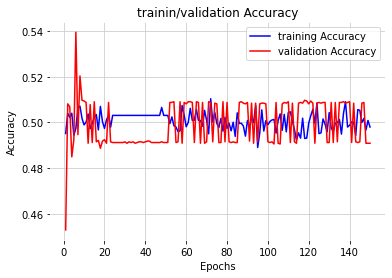

In [60]:
# plotting the the training accuracy
plot_Model_Accuracy(model_history, 150)

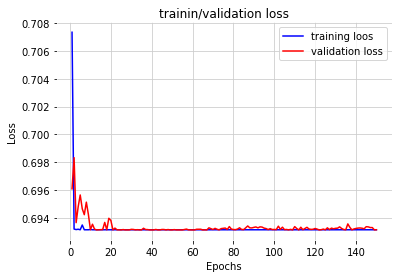

In [61]:
# plotting the the training loss
plot_Model_loss(model_history, 150)

[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [1]]
[0 0 0 ... 0 0 0]


<Figure size 432x288 with 0 Axes>

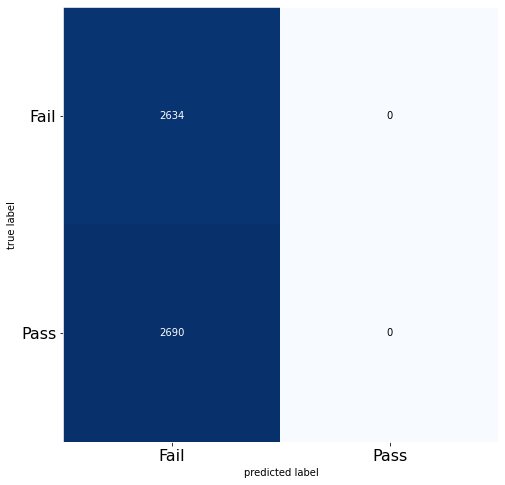

Accuracy of the model is 0.49474
Recall of the model is 0.00000
Precision of the model is nan
specificity of the model is 1.00000
F1_score of the model is 0.00000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


In [62]:
# Evaluating my model using CM, precsion, and recal
preds, original_test_labels = get_Model_prediction(model, test_data, test_labels)
get_Evaluation_matrics(preds, original_test_labels)

AUC Score :  0.5


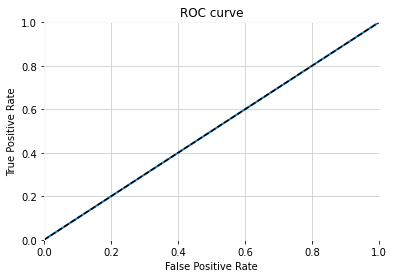

In [63]:
# plotting the AUC for all my classes
get_model_ROC_AUC_curve(preds, test_labels)

# **2. machining_finalized**

**XG Boost**

In [64]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

label2 = Data.machining_finalized
train_data, test_data, train_labels, test_labels = train_test_split(s_features, label2, test_size = 0.20, random_state = 123)

<Figure size 360x360 with 0 Axes>

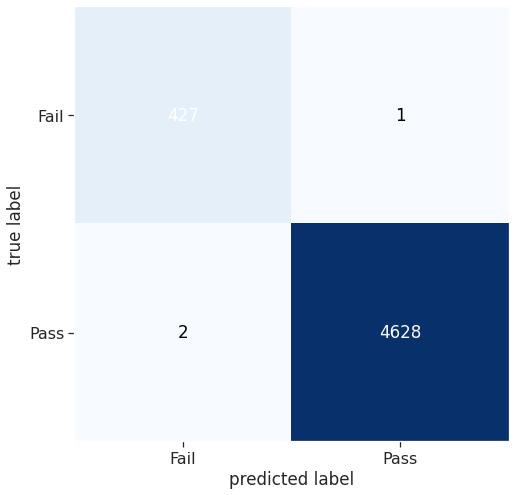

Accuracy of the model is 0.99941
Recall of the model is 0.99957
Precision of the model is 0.99978
specificity of the model is 0.99766
F1_score of the model is 0.99968


In [ ]:
model = XGBClassifier()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9986157929795522


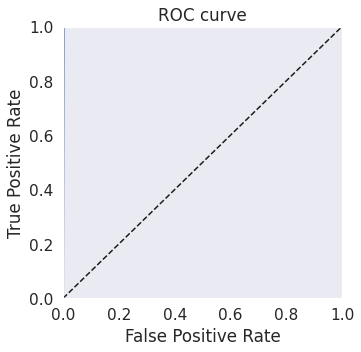

In [ ]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**RF**

<Figure size 360x360 with 0 Axes>

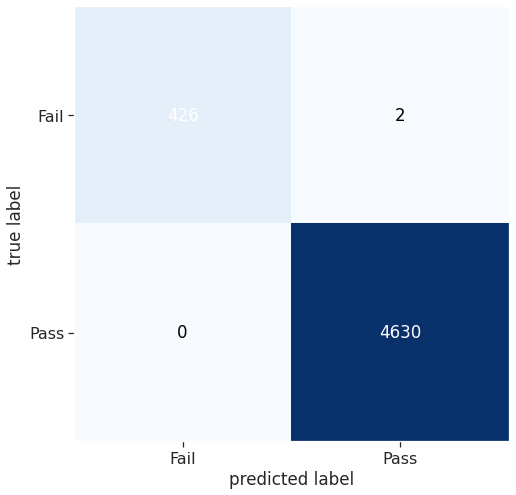

Accuracy of the model is 0.99960
Recall of the model is 1.00000
Precision of the model is 0.99957
specificity of the model is 0.99533
F1_score of the model is 0.99978


In [ ]:
model = RandomForestClassifier()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9988317757009345


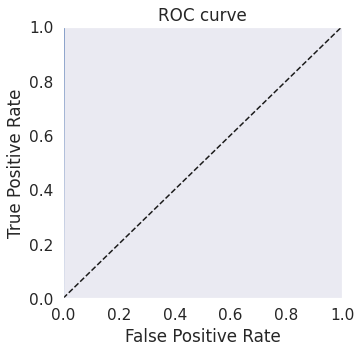

In [ ]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**SVC**

<Figure size 432x288 with 0 Axes>

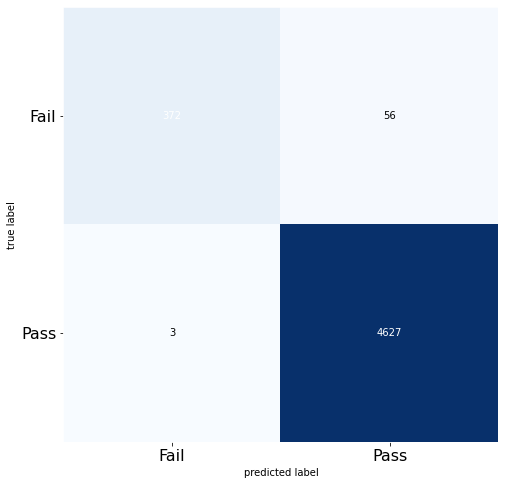

Accuracy of the model is 0.98834
Recall of the model is 0.99935
Precision of the model is 0.98804
specificity of the model is 0.86916
F1_score of the model is 0.99366


In [65]:
model = SVC()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.934255465170263


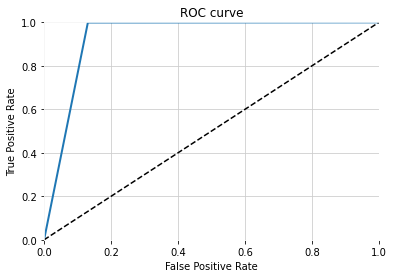

In [66]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**ANN**

# **3. passed_visual_inspection**

**XG Boost**

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

label2 = Data.passed_visual_inspection
train_data, test_data, train_labels, test_labels = train_test_split(s_features, label2, test_size = 0.20, random_state = 123)

<Figure size 360x360 with 0 Axes>

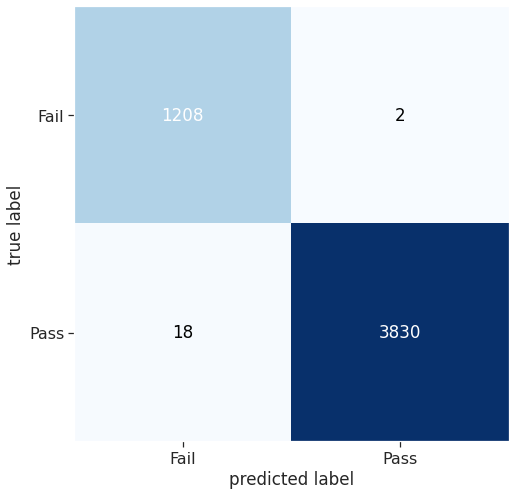

Accuracy of the model is 0.99605
Recall of the model is 0.99532
Precision of the model is 0.99948
specificity of the model is 0.99835
F1_score of the model is 0.99740


In [ ]:
model = XGBClassifier()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9968346763801311


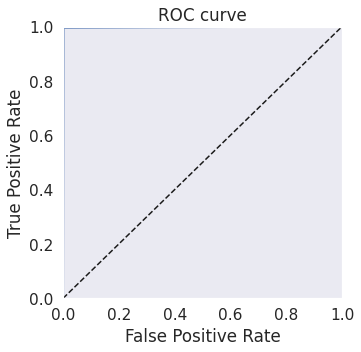

In [ ]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**RF**

<Figure size 360x360 with 0 Axes>

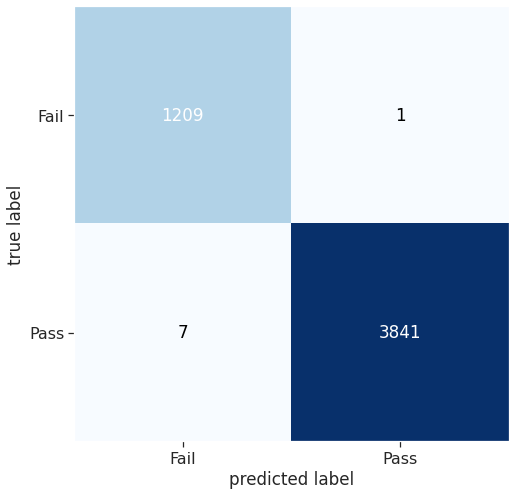

Accuracy of the model is 0.99842
Recall of the model is 0.99818
Precision of the model is 0.99974
specificity of the model is 0.99917
F1_score of the model is 0.99896


In [ ]:
model = RandomForestClassifier()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9986772134499408


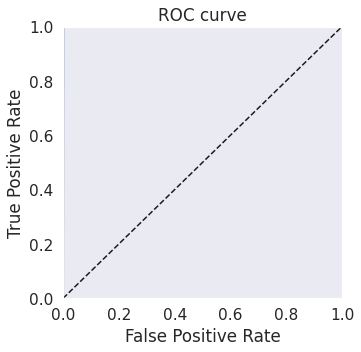

In [ ]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**SVC**

<Figure size 360x360 with 0 Axes>

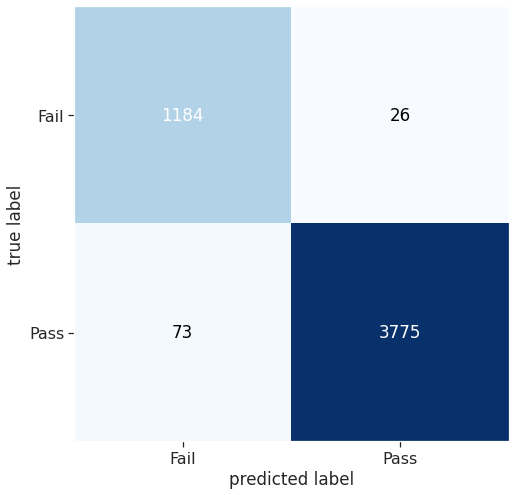

Accuracy of the model is 0.98043
Recall of the model is 0.98103
Precision of the model is 0.99316
specificity of the model is 0.97851
F1_score of the model is 0.98706


In [ ]:
model = SVC()

model.fit(train_data, train_labels)

preds = model.predict(test_data)

get_Evaluation_matrics(preds, test_labels)

AUC Score :  0.9797707513616604


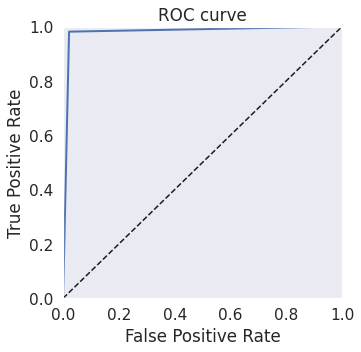

In [ ]:
#plotting the ROC Curve of the model
get_model_ROC_AUC_curve(preds, test_labels)

**ANN**